# Haiku generator with LSTM


Haiku dataset https://www.kaggle.com/hjhalani30/haiku-dataset

# 1. Data preparation and cleaning

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import sys
import keras
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v1.disable_eager_execution()

In [3]:
dirname = os.getcwd()
filename = "all_haiku.csv"
path_to_dataset = os.path.join(dirname, filename)
n_examples = 124295
data = pd.read_csv(path_to_dataset, delimiter=',', nrows = n_examples)
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

#cols 1-3 are 1st, 2nd, and 3rd lines of the haiku respectively

There are 124295 rows and 6 columns


In [4]:
data = data.to_numpy()

In [5]:
#cols 1-3 are 1st, 2nd, and 3rd lines of the haiku respectively

X_1_0 = data[:,1]
X_2_0 = data[:,2]
X_3_0 = data[:,3]

In [6]:
X_1 = []
X_2 = []
X_3 = []
for i in range(n_examples):
    if type(X_1_0[i]) == str and type(X_2_0[i]) == str and type(X_3_0[i]) == str:
        X_1.append(X_1_0[i])
        X_2.append(X_2_0[i])
        X_3.append(X_3_0[i])

In [7]:
#clean the data to get rid off "-" etc
#to make it sensitive to lines, maybe we could implement a line break as some symbol e.g. "|" and merge the X's together
punctuation = ['-', '--', '~', '—', '.', ';', ',', ':', '?', '!', '#', '(', ')', '<', '>', '*', '%', '{', '_', ']', '[', '@', '`', '\xa0', '=', '"', '&', '–', '…', '“', '”']

end_of_line = '.'
end_of_haiku = '/'

for i in range(len(X_1)):
    for p in punctuation:
        if p in X_1[i]:
            X_1[i] = X_1[i].replace(p, '')
        if p in X_2[i]:
            X_2[i] = X_2[i].replace(p, '')
        if p in X_3[i]:
            X_3[i] = X_3[i].replace(p, '')
   
    #delete redundant spaces
    if X_1[i][-3:-1] == '   ':
        X_1[i] = X_1[i].replace('   ', '')
    elif X_1[i][-2:-1] == '  ':
        X_1[i] = X_1[i].replace('  ', '')   
    elif X_1[i][-1] == ' ':
        X_1[i] = X_1[i].replace(' ', '')
    
    if X_2[i][-3:-1] == '   ':
        X_2[i] = X_2[i].replace('   ', '')
    elif X_2[i][-2:-1] == '  ':
        X_2[i] = X_2[i].replace('  ', '')   
    elif X_1[i][-1] == ' ':
        X_2[i] = X_2[i].replace(' ', '')
        
    if X_3[i][-3:-1] == '   ':
        X_3[i] = X_1[i].replace('   ', '')
    elif X_3[i][-2:-1] == '  ':
        X_3[i] = X_1[i].replace('  ', '')   
    elif X_3[i][-1] == ' ':
        X_1[i] = X_1[i].replace(' ', '')
    

    
    #X_1[i] += end_of_line
    #X_2[i] += end_of_line
    #X_3[i] += end_of_line
    #X_3[i] += end_of_haiku
    


In [8]:
haiku_vec = []
for i in range(len(X_1)):
    haiku = X_1[i].split()
    haiku.append('/')
    for word in X_2[i].split():
        haiku.append(word)
    haiku.append('/')
    for word in X_3[i].split():
        haiku.append(word)
    haiku.append('/')
    haiku_vec.append(haiku)

In [9]:
haikus = haiku_vec


In [10]:
short_haikus = []
for i in range(len(haikus)):
    if len(haikus[i]) == 13:
        short_haikus.append(haikus[i])
n_haikus = len(short_haikus)
print(n_haikus)

haikus = short_haikus

8394


In [11]:
max_len = 0
for i in range(n_haikus):
    max_len = max(max_len, len(haikus[i]))
    
print(max_len)

13


In [12]:
#create words dict

token_index = {}
idx = -1
for haiku in haikus:
    for i in range(len(haiku)):
        if haiku[i] not in token_index:
            token_index[haiku[i]] = idx+1
            idx += 1

In [13]:
vocab_size = len(token_index)
print(vocab_size)
#our total length is 5x times that

15889


In [14]:
token_index

{'fly': 0,
 'fishing': 1,
 '/': 2,
 'the': 3,
 'sound': 4,
 'of': 5,
 'wind': 6,
 'in': 7,
 'reel': 8,
 'visiting': 9,
 'graves': 10,
 'stronger': 11,
 'October': 12,
 'at': 13,
 'my': 14,
 "grandparents'": 15,
 'early': 16,
 'morning': 17,
 'dew': 18,
 'squeezing': 19,
 'last': 20,
 'drop': 21,
 'from': 22,
 'teabag': 23,
 'winter': 24,
 'roses': 25,
 'I': 26,
 'am': 27,
 'tired': 28,
 'reading': 29,
 'between': 30,
 'lines': 31,
 'night': 32,
 'shift': 33,
 'a': 34,
 'quick': 35,
 'break': 36,
 'to': 37,
 'look': 38,
 'stars': 39,
 'freeze': 40,
 'warning': 41,
 'light': 42,
 'arc': 43,
 'welder': 44,
 'brightens': 45,
 'need': 46,
 'pee': 47,
 'once': 48,
 'we': 49,
 'hit': 50,
 'traffic': 51,
 'out': 52,
 'fog': 53,
 'white': 54,
 'barn': 55,
 'with': 56,
 'painted': 57,
 'butterflies': 58,
 'distanthurricane': 59,
 'middle': 60,
 'rain': 61,
 'phone': 62,
 'rings': 63,
 'waiting': 64,
 'for': 65,
 'bus': 66,
 'street': 67,
 'dog': 68,
 'sniffs': 69,
 'shadow': 70,
 'windowpane': 7

Now that we have turned characters into tokens with corresponding indexes we can vectorise our training examples by one-hot-encoding them and subsequently creating 3D numpy arrays for X and Y:

`X`: This is an (n_haikus, max_len, vocab_size) dimensional array.
- We have max_len timesteps for each training example
- At each time step the input is one of vocab_size possible values and is represented as a one-hot vector. e.g. X[i,t,:] is a one-hot vector representing the value of the i-th example at time t. 

`Y`: a (max_len, n_haikus, vocab_size) dimensional array

We're using the previous values to predict the next value. Therefore each traing example Y is just training example X moved one step ahead.

In [15]:
max_len = max_len - 1

In [16]:
X = np.zeros((n_haikus, max_len, vocab_size), dtype = 'float32')
Y = np.zeros((max_len, n_haikus, vocab_size), dtype = 'float32')

In [17]:
#vectorise haikus - turn them into a list of char/word indexes
haiku_vectors = []
for i, haiku in enumerate(haikus):
    haiku_vec = []
    for j in range(len(haiku)):
        haiku_vec.append(token_index.get(haiku[j]))
    haiku_vectors.append(haiku_vec)

In [18]:
X_vec = []
Y_vec = []
for i, vec in enumerate(haiku_vectors):
    X_vec.append(vec[:-1])
    Y_vec.append(vec[1:])


In [19]:
for i, vec in enumerate(X_vec):
    for j, idx in enumerate(vec):
        X[i, j, idx] = 1
        
for i, vec in enumerate(Y_vec):
    for j, idx in enumerate(vec):
        Y[j, i, idx] = 1

# 2. Building an LSTM model

In [20]:
#number of dimensions for hidden state (a) of each LSTM cell
n_a = 2000

We implement LSTM forward pass defined by the following:

Forget gate:

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$

Candidate value:

$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$

Update gate:

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$ 

Cell state:
$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$

Output gate:
$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$ 

Hidden state:
$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

Prediction:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

We want to generate new characters at test time predicting the next character based on the last character and the parameters (which can pass information about previous characters too) so we need to build LSTM architecture which implements such inference. So we use keras functional API to build a custom model.

We build a model by stacking keras layers on top of one another:
1. Input layer (specifying shape of input) 
- tensorflow.keras.layers.Input() class
2. 


LSTM_cell:

Takes hidden state as input and returns the next hidden state

dense_layer:

Dense implements the operation: output = activation(dot(input, kernel) + bias) where:
- activation = element-wise activation function passed as the activation argument
- kernel = weights matrix created by the layer
- bias = bias vector created by the layer 

Thus here we use Dense to calculated y_pred = softmax(dot(Wya, a) + by)

In [21]:
#define the layer objects of the model globally so that they are fixed when used in a model function

LSTM_cell = LSTM(n_a, return_state = True) #shape of output is n_a, and of weight n_a x input[0]

prediction_layer = Dense(vocab_size, activation='softmax')

reshape_layer = Reshape((1, vocab_size)) 

In [22]:
def LSTM_model(max_len, n_a, vocab_size):
    
    #specify the shape of input X
    X = Input(shape=(max_len, vocab_size))
    
    #specify the size of accepted a0 and c) inputs
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    
    #initiliase cell state and hidden state
    a = a0
    c = c0
    
    #create an empty list to append predictions (outputs of Dense)
    outputs = []
    
    for t in range(max_len):
        
        #adds a layer for the next input (i.e. next character and next timestep)
        #lambda allows to specify the operation to be applied as a function on a tensor in a layer
        #here it just takes a slice of x for a given timestep and returns it
        x_t = Lambda(lambda x_t: X[:,t,:])(X) #each takes a slice of X as input so this is a slicing layer
        
        # reshapes x to be (1, vocab_size) 
        x_t = reshape_layer(x_t) #reshapes the slice
        
        #one step of LSTM to update hidden state and cell state
        a, _, c = LSTM_cell(x_t, initial_state=[c, a])
        
        #apply softmax to a function of hidden state to get prediction
        output = prediction_layer(a)
        
        outputs.append(output)
        
    model = Model(inputs= [X,a0,c0], outputs= outputs)
    
    return model
        
        
    

In [23]:
#def our model
model = LSTM_model(max_len = max_len , n_a = n_a, vocab_size = vocab_size)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 15889)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15889)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 15889)     0           lambda[0][0]                     
                                                                 lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]               

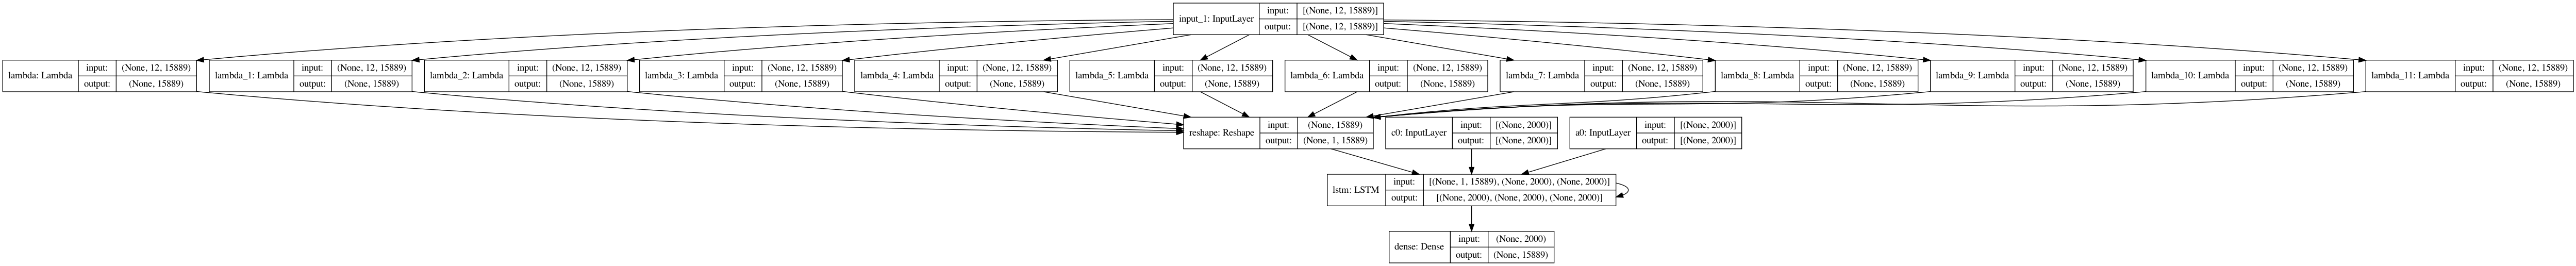

In [25]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

#should be seversl outputs and several lstm layers

In [26]:
#compile the model

optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.9999, decay=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
k = n_haikus
a0 = np.zeros((k, n_a))
c0 = np.zeros((k, n_a))

In [28]:
history = model.fit([X, a0, c0], list(Y), epochs=60)

Train on 8394 samples
Epoch 1/60
8394/8394 [==============================] - 1523s 181ms/sample - loss: 83.1628 - dense_loss: 8.2665 - dense_1_loss: 6.1961 - dense_2_loss: 5.2940 - dense_3_loss: 6.9964 - dense_4_loss: 8.6333 - dense_5_loss: 8.8722 - dense_6_loss: 7.4947 - dense_7_loss: 5.4899 - dense_8_loss: 6.3336 - dense_9_loss: 8.3894 - dense_10_loss: 10.5516 - dense_11_loss: 0.6498 - dense_accuracy: 0.0341 - dense_1_accuracy: 0.2875 - dense_2_accuracy: 0.3897 - dense_3_accuracy: 0.2217 - dense_4_accuracy: 0.0361 - dense_5_accuracy: 0.0336 - dense_6_accuracy: 0.2224 - dense_7_accuracy: 0.4076 - dense_8_accuracy: 0.2676 - dense_9_accuracy: 0.0354 - dense_10_accuracy: 1.1913e-04 - dense_11_accuracy: 0.9656
Epoch 2/60
8394/8394 [==============================] - 1568s 187ms/sample - loss: 79.6372 - dense_loss: 5.7418 - dense_1_loss: 4.8539 - dense_2_loss: 4.6116 - dense_3_loss: 6.6532 - dense_4_loss: 8.5337 - dense_5_loss: 8.9976 - dense_6_loss: 7.6220 - dense_7_loss: 5.4349 - dense_8

8394/8394 [==============================] - 1576s 188ms/sample - loss: 30.3618 - dense_loss: 2.1880 - dense_1_loss: 0.6175 - dense_2_loss: 0.8808 - dense_3_loss: 1.5492 - dense_4_loss: 2.8264 - dense_5_loss: 3.4698 - dense_6_loss: 3.5102 - dense_7_loss: 2.8517 - dense_8_loss: 3.1474 - dense_9_loss: 4.1465 - dense_10_loss: 4.8682 - dense_11_loss: 0.3207 - dense_accuracy: 0.4052 - dense_1_accuracy: 0.8413 - dense_2_accuracy: 0.7542 - dense_3_accuracy: 0.6234 - dense_4_accuracy: 0.3528 - dense_5_accuracy: 0.2231 - dense_6_accuracy: 0.2645 - dense_7_accuracy: 0.4381 - dense_8_accuracy: 0.3357 - dense_9_accuracy: 0.1370 - dense_10_accuracy: 0.0518 - dense_11_accuracy: 0.9954
Epoch 13/60
8394/8394 [==============================] - 1567s 187ms/sample - loss: 28.4287 - dense_loss: 2.1558 - dense_1_loss: 0.5749 - dense_2_loss: 0.7991 - dense_3_loss: 1.3613 - dense_4_loss: 2.6036 - dense_5_loss: 3.2359 - dense_6_loss: 3.2916 - dense_7_loss: 2.6986 - dense_8_loss: 2.9751 - dense_9_loss: 3.9624 

8394/8394 [==============================] - 1610s 192ms/sample - loss: 18.3517 - dense_loss: 1.9818 - dense_1_loss: 0.4134 - dense_2_loss: 0.4243 - dense_3_loss: 0.5735 - dense_4_loss: 1.3187 - dense_5_loss: 1.9196 - dense_6_loss: 2.1220 - dense_7_loss: 1.7333 - dense_8_loss: 2.0811 - dense_9_loss: 2.7543 - dense_10_loss: 2.9764 - dense_11_loss: 0.0472 - dense_accuracy: 0.4130 - dense_1_accuracy: 0.8700 - dense_2_accuracy: 0.8620 - dense_3_accuracy: 0.8449 - dense_4_accuracy: 0.6931 - dense_5_accuracy: 0.5071 - dense_6_accuracy: 0.4056 - dense_7_accuracy: 0.5230 - dense_8_accuracy: 0.4004 - dense_9_accuracy: 0.2109 - dense_10_accuracy: 0.1644 - dense_11_accuracy: 0.9995
Epoch 24/60
8394/8394 [==============================] - 1638s 195ms/sample - loss: 17.8001 - dense_loss: 1.9672 - dense_1_loss: 0.4118 - dense_2_loss: 0.4054 - dense_3_loss: 0.5487 - dense_4_loss: 1.2580 - dense_5_loss: 1.8505 - dense_6_loss: 2.0666 - dense_7_loss: 1.6791 - dense_8_loss: 2.0172 - dense_9_loss: 2.6911 

8394/8394 [==============================] - 1688s 201ms/sample - loss: 14.5106 - dense_loss: 1.9018 - dense_1_loss: 0.3611 - dense_2_loss: 0.3181 - dense_3_loss: 0.3780 - dense_4_loss: 0.8590 - dense_5_loss: 1.3732 - dense_6_loss: 1.6594 - dense_7_loss: 1.3468 - dense_8_loss: 1.6668 - dense_9_loss: 2.2396 - dense_10_loss: 2.3813 - dense_11_loss: 0.0296 - dense_accuracy: 0.4204 - dense_1_accuracy: 0.8699 - dense_2_accuracy: 0.8805 - dense_3_accuracy: 0.8778 - dense_4_accuracy: 0.7829 - dense_5_accuracy: 0.6640 - dense_6_accuracy: 0.4963 - dense_7_accuracy: 0.5847 - dense_8_accuracy: 0.4699 - dense_9_accuracy: 0.2694 - dense_10_accuracy: 0.2362 - dense_11_accuracy: 0.9998
Epoch 35/60
8394/8394 [==============================] - 1704s 203ms/sample - loss: 14.2467 - dense_loss: 1.8971 - dense_1_loss: 0.3596 - dense_2_loss: 0.3126 - dense_3_loss: 0.3650 - dense_4_loss: 0.8350 - dense_5_loss: 1.3390 - dense_6_loss: 1.6220 - dense_7_loss: 1.3154 - dense_8_loss: 1.6246 - dense_9_loss: 2.2092 

8394/8394 [==============================] - 1640s 195ms/sample - loss: 11.7553 - dense_loss: 1.8593 - dense_1_loss: 0.3305 - dense_2_loss: 0.2586 - dense_3_loss: 0.3001 - dense_4_loss: 0.6676 - dense_5_loss: 1.0582 - dense_6_loss: 1.3118 - dense_7_loss: 1.0480 - dense_8_loss: 1.2993 - dense_9_loss: 1.7950 - dense_10_loss: 1.7956 - dense_11_loss: 0.0211 - dense_accuracy: 0.4276 - dense_1_accuracy: 0.8709 - dense_2_accuracy: 0.8928 - dense_3_accuracy: 0.8893 - dense_4_accuracy: 0.8156 - dense_5_accuracy: 0.7549 - dense_6_accuracy: 0.6366 - dense_7_accuracy: 0.6964 - dense_8_accuracy: 0.6095 - dense_9_accuracy: 0.4472 - dense_10_accuracy: 0.4547 - dense_11_accuracy: 1.0000
Epoch 46/60
8394/8394 [==============================] - 1638s 195ms/sample - loss: 11.5341 - dense_loss: 1.8603 - dense_1_loss: 0.3290 - dense_2_loss: 0.2546 - dense_3_loss: 0.2949 - dense_4_loss: 0.6460 - dense_5_loss: 1.0302 - dense_6_loss: 1.2839 - dense_7_loss: 1.0268 - dense_8_loss: 1.2677 - dense_9_loss: 1.7639 

8394/8394 [==============================] - 1617s 193ms/sample - loss: 9.7359 - dense_loss: 1.8329 - dense_1_loss: 0.3071 - dense_2_loss: 0.2189 - dense_3_loss: 0.2477 - dense_4_loss: 0.5216 - dense_5_loss: 0.8215 - dense_6_loss: 1.0282 - dense_7_loss: 0.8283 - dense_8_loss: 1.0176 - dense_9_loss: 1.4215 - dense_10_loss: 1.4925 - dense_11_loss: 0.0100 - dense_accuracy: 0.4299 - dense_1_accuracy: 0.8743 - dense_2_accuracy: 0.9076 - dense_3_accuracy: 0.9053 - dense_4_accuracy: 0.8495 - dense_5_accuracy: 0.8200 - dense_6_accuracy: 0.7460 - dense_7_accuracy: 0.7782 - dense_8_accuracy: 0.7094 - dense_9_accuracy: 0.5870 - dense_10_accuracy: 0.5617 - dense_11_accuracy: 1.0000
Epoch 57/60
8394/8394 [==============================] - 1616s 192ms/sample - loss: 9.6125 - dense_loss: 1.8286 - dense_1_loss: 0.3098 - dense_2_loss: 0.2153 - dense_3_loss: 0.2474 - dense_4_loss: 0.5123 - dense_5_loss: 0.8064 - dense_6_loss: 1.0067 - dense_7_loss: 0.8138 - dense_8_loss: 0.9973 - dense_9_loss: 1.3927 - 

In [29]:
path = os.getcwd()+'/LSTMmodel'
model.save(path)

AssertionError: Tried to export a function which references untracked resource Tensor("input_1_1:0", shape=(None, 12, 15889), dtype=float32).TensorFlow objects (e.g. tf.Variable) captured by functions must be tracked by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly.

Trackable Python objects referring to this tensor (from gc.get_referrers, limited to two hops):


## Sampling with temperature

In [30]:
def sample_vec(prob_vec, temperature):
    #prob_vec = np.array(prob_vec).as_type('float64')
    prob_vec = tf.math.divide(tf.math.log(prob_vec),temperature)
    exp_prob_vec = tf.math.exp(prob_vec)
    p = tf.math.divide(exp_prob_vec, tf.math.reduce_sum(exp_prob_vec)) #normalize
    
    dist = tfp.distributions.Multinomial(total_count = 1, probs = p) #draw samples from multinomial dsitribution with p = prob, of given output
    sample = dist.sample()
    print(sample.shape)
    print(sample)
    
    y = K.argmax(sample)
    y = tf.one_hot(indices=y, depth= vocab_size)
    y = RepeatVector(1)(y) 
    print(y.shape)
    return y

In [33]:
def generate_sequence(LSTM_cell, prediction_layer, n_values = vocab_size, n_a = n_a, length = max_len, temperature = temperature):
    
    x0 = Input(shape=(1, n_values))
    
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    
    a = a0
    c = c0
    x = x0
    
    outputs = []
    
    for t in range(length):
        x = reshape_layer(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c]) #or [c,a]
        pred = prediction_layer(a)
        y = Lambda(lambda a: sample_vec(a,temperature))(pred)
        outputs.append(y)
        x = y
        #RepeatVector(1)(y)
    
    inference_model = tf.keras.Model(inputs=[x0,a0,c0], outputs=outputs)
    return inference_model

In [32]:
temperature = 3

In [34]:
inference_model = generate_sequence(LSTM_cell, prediction_layer, n_values = vocab_size, n_a = n_a, length = max_len, temperature = temperature)

(None, 15889)
Tensor("lambda_12/lambda_12_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_13/lambda_13_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_14/lambda_14_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_15/lambda_15_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_16/lambda_16_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_17/lambda_17_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_18/lambda_18_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1, 15889)
(None, 15889)
Tensor("lambda_19/lambda_19_Multinomial/sample/Reshape:0", shape=(None, 15889), dtype=float32)
(None, 1,

## Prediction

In [35]:
x_init = np.zeros((1, 1, vocab_size))
a_init = np.zeros((1, n_a))
c_init = np.zeros((1, n_a))

In [36]:
x_init.shape

(1, 1, 15889)

In [94]:
def predict_sequence(inference_model = inference_model, x_nit = x_init, a_init = a_init, c_init = c_init):
    predictions = inference_model.predict([x_init, a_init, c_init])
    print(predictions[0])
    print(predictions[0][0][0])
    print(len(predictions[0][0][0]))
    indices = np.argmax(predictions, axis=-1)
    print(indices)
    #print(predictions[0][0][0][indices])
    results = []
    for i in range(max_len):
        results.append(indices[i,0,0])
        print(indices[i,0,0])
    return results

In [95]:
index_token = {}
for key, value in token_index.items():
    index_token[value] = key
    

In [96]:
#find a way to parametrize with temperature!

def get_haiku():
    pred = predict_sequence(inference_model = inference_model, x_nit = x_init, a_init = a_init, c_init = c_init)
    sequence = []
    for elem in pred:
        sequence.append(index_token[elem])
    for elem in sequence:
        print(elem)

In [97]:
#get_haiku()

In [98]:
get_haiku()

[[[0. 0. 0. ... 0. 0. 0.]]]
[0. 0. 0. ... 0. 0. 0.]
15889
[[[12952]]

 [[    2]]

 [[    2]]

 [[  117]]

 [[   99]]

 [[   99]]

 [[   99]]

 [[    5]]

 [[   56]]

 [[  224]]

 [[ 1084]]

 [[  540]]]
12952
2
2
117
99
99
99
5
56
224
1084
540
airborne
/
/
long
on
on
on
of
with
it
today
it's


In [45]:
get_haiku()

12
neophyte
waddles
in
on
and
cooking
to
in
when
on
your
come


In [ ]:
get_haiku()